# Load e imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

# Avaliando modelo por liga

## Preprocessamento

In [3]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

## Treinamento

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
for league in leagues:
    print(f"Treinando modelo para a liga: {league}")
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    
    model_randomf = RandomForestClassifier(n_estimators=100, random_state=42, 
                                           max_depth=10, min_samples_split=5, 
                                            min_samples_leaf=2)

    # model_randomf = RandomForestClassifier(n_estimators=200)
    
    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

Treinando modelo para a liga: South America - Copa Libertadores
Média AUC para South America - Copa Libertadores: 0.9376655460117203
Média Acurácia para South America - Copa Libertadores: 0.8441732627458265
Treinando modelo para a liga: Asia - AFC Champions League
Média AUC para Asia - AFC Champions League: 0.9491847518908484
Média Acurácia para Asia - AFC Champions League: 0.8586433492315846
Treinando modelo para a liga: Brazil - Paulista A1
Média AUC para Brazil - Paulista A1: 0.9460332280137755
Média Acurácia para Brazil - Paulista A1: 0.8705312371483611
Treinando modelo para a liga: South America - Copa Sudamericana
Média AUC para South America - Copa Sudamericana: 0.956216153182561
Média Acurácia para South America - Copa Sudamericana: 0.8707014460580274
Treinando modelo para a liga: Japan - J-League
Média AUC para Japan - J-League: 0.9141403306420607
Média Acurácia para Japan - J-League: 0.7990196078431373
Treinando modelo para a liga: USA - Major League Soccer
Média AUC para USA

## Avaliando importancia das features de cada liga

In [5]:
# # Suponha que X_train tenha os nomes das features e league_histories contenha as importâncias
# feature_names = X.columns

# # Loop para criar um gráfico para cada liga
# for league, data in league_histories.items():
#     # Ordenar as características e suas importâncias
#     sorted_idx = np.argsort(data['feature_importance'])
#     sorted_feature_names = feature_names[sorted_idx]
#     sorted_importances = data['feature_importance'][sorted_idx]

#     # Criando o gráfico
#     plt.figure(figsize=(10, 8))
#     plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
#     plt.title(f'Feature Importance for {league}')
#     plt.xlabel('Importance')
#     plt.ylabel('Features')
#     plt.show()


In [6]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
# dataframe_league.to_csv('dataframe_leagues_avaliation_before_f_engineering.csv', index=False, encoding='utf-8')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.844173,0.977402,0.948586,"[0.23380391414375268, 0.05299796308408905, 0.0..."
Asia - AFC Champions League,0.858643,0.984658,0.954541,"[0.2457864171306063, 0.040379348471482175, 0.0..."
Brazil - Paulista A1,0.870531,0.981911,0.961284,"[0.23201652778997636, 0.05174544652324218, 0.0..."
South America - Copa Sudamericana,0.870701,0.988072,0.948622,"[0.22066832576004283, 0.07094391590588611, 0.0..."
Japan - J-League,0.799020,0.966683,0.911725,"[0.2344534510452039, 0.05385399010649874, 0.05..."
USA - Major League Soccer,0.785014,0.952764,0.907272,"[0.27318628344358953, 0.05134242511628713, 0.0..."
Mexico - Liga MX,0.817721,0.969423,0.932617,"[0.2128205486787047, 0.06017349813358775, 0.05..."
Scotland - Premiership,0.864828,0.985359,0.945825,"[0.1926427834958494, 0.04945579500783469, 0.03..."
Brazil - Serie A,0.805537,0.956839,0.890989,"[0.2522736945517624, 0.06603561408042823, 0.05..."
France - Ligue 1,0.856970,0.977188,0.915002,"[0.1893760598889748, 0.046401124004755274, 0.0..."


In [7]:
# Calculando a média da importância de cada característica em todas as ligas
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# Convertendo a lista de importâncias das características em um DataFrame para facilitar a análise
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculando a variância da importância de cada característica em todas as ligas
feature_variances = df_feature_importances.var()

# Criando um DataFrame resumo para conter os dados de variância e correlação
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Exibindo o DataFrame resumo ordenado por variância para ver quais características têm mais variabilidade entre as ligas
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns
# feature_names = df.drop(['result', 'league'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])

summary_df.sort_values('Mean Importance', ascending=False)


,Feature,Mean Importance,Variance,Feature Name
0,0,0.215230,0.001087,minute
3,20,0.067236,0.000087,tackles_away
2,19,0.063243,0.000097,tackles_home
8,22,0.060706,0.000051,possessiontime_home
7,21,0.060681,0.000055,possessiontime_away
5,15,0.059199,0.000058,fouls_home
1,16,0.058481,0.000098,fouls_away
6,1,0.049818,0.000058,shotsHome
4,2,0.046760,0.000075,shotsAway
12,9,0.040547,0.000041,shotsOffgoal_home


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

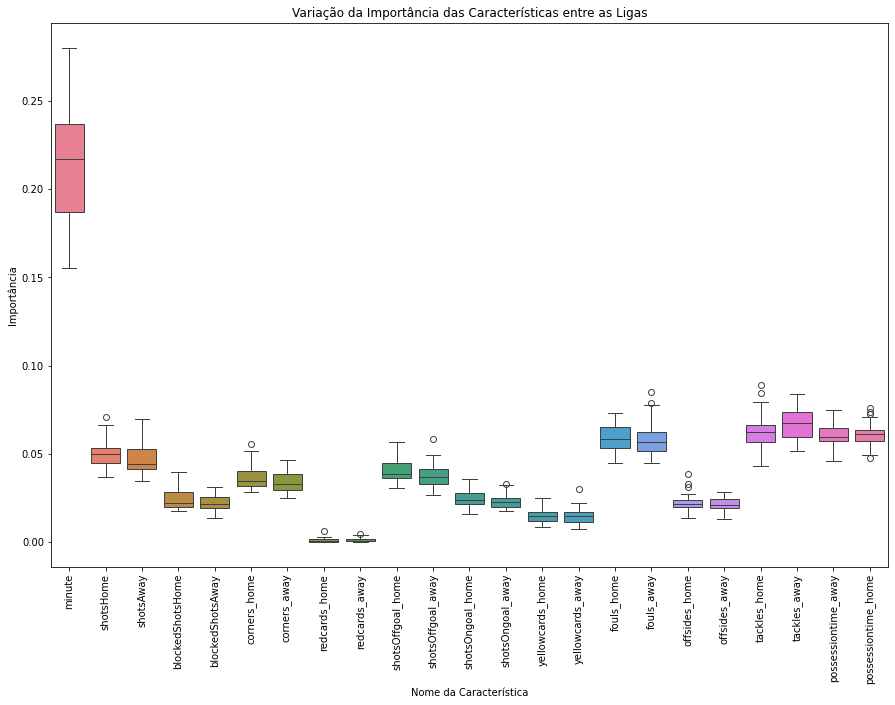

In [8]:
# Conversão do que ta no dataframe para lista
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

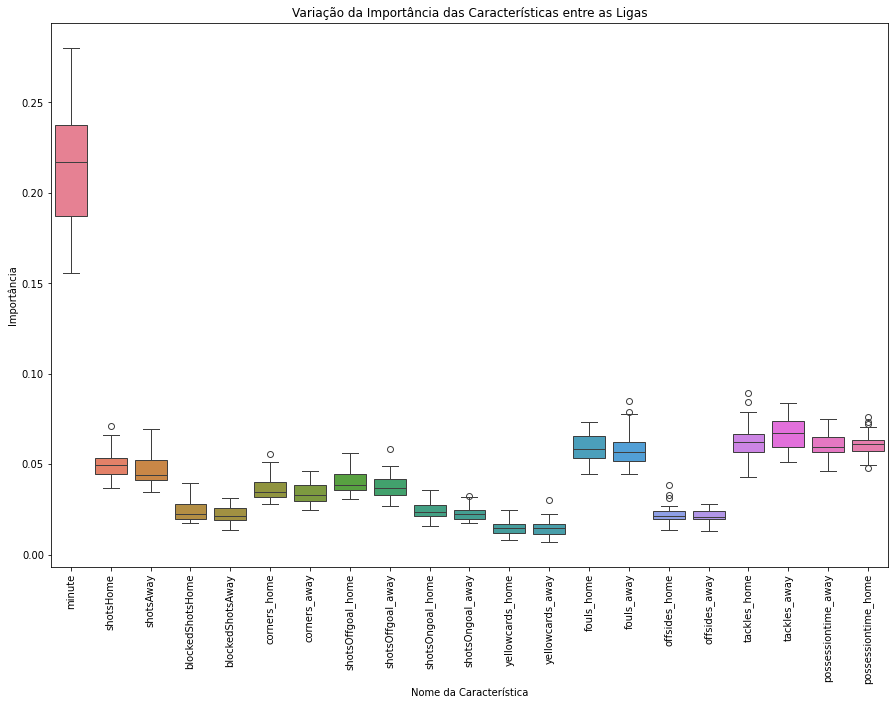

In [16]:
low_importance_features_indices = summary_df[summary_df['Mean Importance'] <= 0.014686]['Feature'].tolist()
# low_importance_features_indices2 = summary_df[summary_df['Variance'] >= 0.000016]['Feature'].tolist()
# low_importance_features_indices = low_importance_features_indices1 + low_importance_features_indices2

feature_importance_df_filtered = feature_importance_df.drop(columns=low_importance_features_indices, axis=1)

feature_names_filtered = [feature_names[i] for i in range(len(feature_names)) if i not in low_importance_features_indices]

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df_filtered)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names_filtered)), labels=feature_names_filtered, rotation=90)
plt.show()


# Engenharia de recursos

In [17]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

In [18]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'shotsHome', 'shotsAway',
       'blockedShotsHome', 'blockedShotsAway', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'fouls_home', 'fouls_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id', 'possessiontime_away', 'possessiontime_home'],
      dtype='object')

Em 'A League-Wide Evaluation of Factors Influencing Match Activity Profile in Elite Australian Football', Esmaeili, Clifton e Aughey (2020) destacam a complexidade e a multifatorialidade do desempenho em jogos de futebol de elite. As medidas de desempenho utilizadas para o sistema de análise de partidas 'Champdas Master System' foram divididas em 
- Desempenho relacionado ao ataque
- Desempenho relacionado com passes
- Desempenho relacionado com Defesa

Nos dados, as estatisticas,
- de ataque são: shotsOngoal, corners
- relacionada a passes: possessiontime
- relacionado a defesa: tackles, blockedShots

Anotações: Essas variáveis do artigo foram utilizadas para interpretar o impacto com os proprios dados do jogo. O trabalho presente avalia essas características como variáveis preditoras

In [19]:
# Desempenho Relacionado ao Ataque
df['shotsOnGoalEfficiency'] = (df['shotsOngoal_home'] + df['shotsOngoal_away']) / (df['shotsHome'] + df['shotsAway'] + 1) # A eficiência do ataque em termos de chutes que realmente vão em direção ao gol.
df['attackPressure'] = (df['shotsHome'] + df['shotsAway'] + df['corners_home'] + df['corners_away']) / df['minute'] # Uma medida de quão ofensivas as equipes estão ao longo do jogo.
df['shotAccuracy_home'] = round(df['shotsOngoal_home'] / (df['shotsHome'] + 1), 2) # Proporção de chutes no gol em relação ao total de chutes.
df['shotAccuracy_away'] = round(df['shotsOngoal_away'] / (df['shotsAway'] + 1), 2)

# Desempenho Relacionado com Passes
df['possessionControl'] = abs(df['possessiontime_home'] - df['possessiontime_away']) # Diferença absoluta do tempo de posse entre as equipes, indicando qual equipe dominou a posse de bola.
df['passRisk'] = (df['offsides_home'] + df['offsides_away']) / (df['possessiontime_home'] + df['possessiontime_away']) # Indicativo de quão arriscados são os passes, resultando em impedimentos.

# Desempenho Relacionado com Defesa
df['defensiveDiscipline'] = (1 - (df['redcards_home'] + df['yellowcards_home'] + df['fouls_home'] + 
                                   df['redcards_away'] + df['yellowcards_away'] + df['fouls_away']) / df['minute']) # Uma medida de quão disciplinadas as equipes estão em termos de cartões e faltas.

df['defensiveEfficacy'] = (df['blockedShotsHome'] + df['blockedShotsAway']) / round((df['shotsOnGoalEfficiency'] + 1), 2) # Avalia a habilidade da defesa de bloquear chutes eficientes.
df['defensiveAggression'] = (df['tackles_home'] + df['tackles_away']) / df['minute'] # Indicativo de quão agressiva a equipe é na defesa ao longo do jogo.

# agora posso excluir características com baixa importância
low_importance_features = summary_df[summary_df['Mean Importance'] <= 0.014686]['Feature Name'].tolist()
print("Características com baixa importância:\n", low_importance_features)

# Removendo as características com baixa importância
df.drop(columns=low_importance_features, inplace=True)

# Visualizar o DataFrame com as novas features
df.head()


Características com baixa importância:
 ['redcards_home', 'redcards_away']


,minute,homeTeam,awayTeam,shotsHome,shotsAway,blockedShotsHome,blockedShotsAway,league,corners_home,corners_away,...,possessiontime_home,shotsOnGoalEfficiency,attackPressure,shotAccuracy_home,shotAccuracy_away,possessionControl,passRisk,defensiveDiscipline,defensiveEfficacy,defensiveAggression
0,30,CR Flamengo,SC Corinthians Paulista,2.0,5.0,0.0,2.0,South America - Copa Libertadores,1.0,1.0,...,60.0,0.250000,0.300000,0.00,0.33,20.0,0.00,0.733333,1.600000,0.333333
1,35,Clube Atlético Mineiro,SE Palmeiras,13.0,1.0,3.0,0.0,South America - Copa Libertadores,2.0,2.0,...,53.0,0.133333,0.514286,0.07,0.50,6.0,0.00,0.485714,2.654867,0.428571
2,40,Argentinos Juniors,CD Universidad Católica,3.0,1.0,1.0,1.0,South America - Copa Libertadores,1.0,1.0,...,50.0,0.000000,0.150000,0.00,0.00,0.0,0.01,0.675000,2.000000,0.250000
3,16,CA River Plate,SE Palmeiras,3.0,1.0,1.0,0.0,South America - Copa Libertadores,2.0,0.0,...,69.0,0.400000,0.375000,0.25,0.50,38.0,0.00,0.687500,0.714286,0.312500
4,26,CSD Independiente del Valle,SE Palmeiras,2.0,1.0,1.0,0.0,South America - Copa Libertadores,1.0,1.0,...,66.0,0.250000,0.192308,0.00,0.50,32.0,0.05,0.846154,0.800000,0.115385


### Desempenho Relacionado ao Ataque
- Eficiência de Ataque: shotsOnGoalEfficiency = (shotsOngoal_home + shotsOngoal_away) / (shotsHome + shotsAway) - Esta feature indicaria a eficiência do ataque em termos de chutes que realmente vão em direção ao gol.

- Pressão de Ataque: attackPressure = (shotsHome + shotsAway + corners_home + corners_away) / minute - Uma medida de quão ofensivas as equipes estão ao longo do jogo.

- Precisão de Chutes: shotAccuracy = (shotsOngoal_home / shotsHome, shotsOngoal_away / shotsAway) - Proporção de chutes no gol em relação ao total de chutes.

### Desempenho Relacionado com Passes
- Controle de Posse: possessionControl = abs(possessiontime_home - possessiontime_away) - Diferença absoluta do tempo de posse entre as equipes, indicando qual equipe dominou a posse de bola.

- Risco de Passe: passRisk = (offsides_home + offsides_away) / (possessiontime_home + possessiontime_away) - Indicativo de quão arriscados são os passes, resultando em impedimentos.

### Desempenho Relacionado com Defesa
- Disciplina Defensiva: defensiveDiscipline = (1 - (redcards_home + yellowcards_home + fouls_home + redcards_away + yellowcards_away + fouls_away) / minute) - Quanto maior esse valor, mais disciplinada é a equipe defensivamente.

        A expressão 1 - é usada para calcular a defensiveDiscipline como uma proporção inversa das infrações cometidas, com a ideia de que uma disciplina defensiva mais alta é refletida por menos infrações. Ao subtrair o total de cartões e faltas pelo tempo de jogo (em minutos), a lógica é que quanto menos infrações uma equipe comete, mais disciplinada ela é defensivamente. 


        Em outras palavras, a fórmula está tentando capturar o seguinte: Se uma equipe não comete faltas ou recebe cartões, sua defensiveDiscipline seria 1 (o que seria considerado perfeito em termos de disciplina).
        Quanto mais faltas e cartões uma equipe acumula, mais esse valor se aproxima de 0, indicando uma menor disciplina defensiva.

- Eficácia da Defesa: defensiveEfficacy = (blockedShotsHome + blockedShotsAway) / (shotsOnGoalEfficiency) - Avalia a habilidade da defesa de bloquear chutes eficientes.

- Agressividade Defensiva: defensiveAggression = (tackles_home + tackles_away) / minute - Indicativo de quão agressiva a equipe é na defesa ao longo do jogo.

In [20]:
df.isnull().sum()

minute                   0
homeTeam                 0
awayTeam                 0
shotsHome                0
shotsAway                0
blockedShotsHome         0
blockedShotsAway         0
league                   0
corners_home             0
corners_away             0
shotsOffgoal_home        0
shotsOffgoal_away        0
shotsOngoal_home         0
shotsOngoal_away         0
yellowcards_home         0
yellowcards_away         0
fouls_home               0
fouls_away               0
offsides_home            0
offsides_away            0
tackles_home             0
tackles_away             0
result                   0
match_id                 0
possessiontime_away      0
possessiontime_home      0
shotsOnGoalEfficiency    0
attackPressure           0
shotAccuracy_home        0
shotAccuracy_away        0
possessionControl        0
passRisk                 0
defensiveDiscipline      0
defensiveEfficacy        0
defensiveAggression      0
dtype: int64

In [21]:
# Verificar a presença de valores infinitos
# print(df.replace([np.inf, -np.inf], np.nan).isnull().sum())

# # Substituir infinitos por NaN e então por um valor numérico ou excluir essas linhas
# df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # substituído pelo último valor não-NaN anterior na coluna.
# df.fillna(method='ffill', inplace=True)

In [22]:
df.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")